<a href="https://colab.research.google.com/github/lmhoang47/CS2225.CH1501/blob/lmhoang47/AgePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# import the necessary packages
import numpy as np
import argparse
import cv2
from google.colab.patches import cv2_imshow
import os

[INFO] loading face detector model...
[INFO] loading age detector model...
[INFO] computing face detections...
[INFO] (25-32): 73.30%


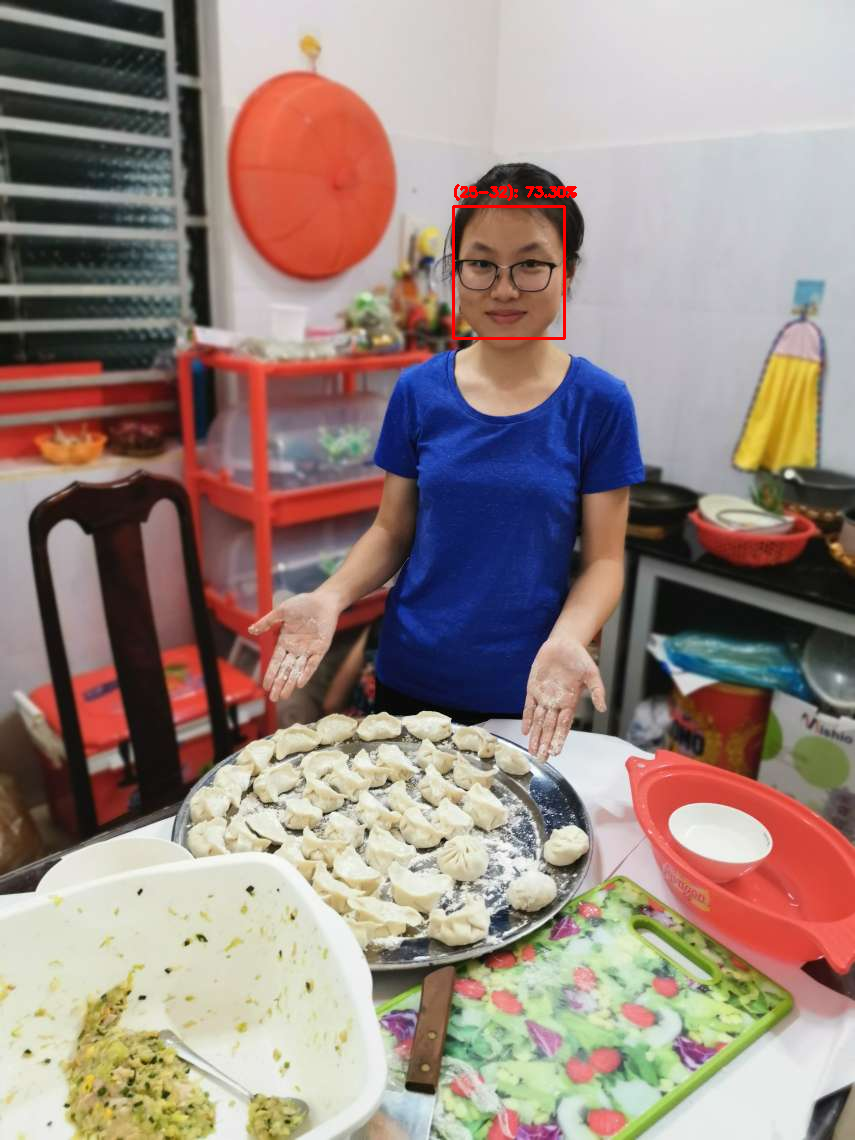

-1

In [75]:
#from google.colab import drive
#drive.mount('/content/drive/')

# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=False,	help="path to input image")
ap.add_argument("-f", "--face", required=True,	help="path to face detector model directory")
ap.add_argument("-a", "--age", required=False,	help="path to age detector model directory")
ap.add_argument("-c", "--confidence", type=float, default=0.5,	help="minimum probability to filter weak detections")
args = vars(ap.parse_args())

# define the list of age buckets our age detector will predict
AGE_BUCKETS = ["(0-2)", "(4-6)", "(8-12)", "(15-20)", "(25-32)", "(38-43)", "(48-53)", "(60-100)"]

# load our serialized face detector model from disk
print("[INFO] loading face detector model...")

args["face"]="/content/drive/My Drive/Classroom/opencv-age-detection/face_detector"
prototxtPath = os.path.sep.join([args["face"], "deploy.prototxt"])
weightsPath = os.path.sep.join([args["face"],	"res10_300x300_ssd_iter_140000.caffemodel"])
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

#args["face"] = "Hoang"
#print("Hi {}".format(args["face"]))

# load our serialized age detector model from disk
print("[INFO] loading age detector model...")
args["age"]="/content/drive/My Drive/Classroom/opencv-age-detection/age_detector"
prototxtPath = os.path.sep.join([args["age"], "age_deploy.prototxt"])
weightsPath = os.path.sep.join([args["age"], "age_net.caffemodel"])
ageNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the input image and construct an input blob for the image
args["image"] = "/content/drive/My Drive/Classroom/opencv-age-detection/images/SuNan.JPEG"
image = cv2.imread(args["image"])
(h, w) = image.shape[:2]
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))

# pass the blob through the network and obtain the face detections
print("[INFO] computing face detections...")
faceNet.setInput(blob)
detections = faceNet.forward()
#cv2_imshow(image)

# loop over the detections
for i in range(0, detections.shape[2]):
	# extract the confidence (i.e., probability) associated with the
	# prediction
	confidence = detections[0, 0, i, 2]
	# filter out weak detections by ensuring the confidence is
	# greater than the minimum confidence
	if confidence > args["confidence"]:
		# compute the (x, y)-coordinates of the bounding box for the
		# object
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")
		# extract the ROI of the face and then construct a blob from
		# *only* the face ROI
		face = image[startY:endY, startX:endX]
		faceBlob = cv2.dnn.blobFromImage(face, 1.0, (227, 227), (78.4263377603, 87.7689143744, 114.895847746), swapRB=False)
	
	# make predictions on the age and find the age bucket with
		# the largest corresponding probability
		ageNet.setInput(faceBlob)
		preds = ageNet.forward()
		i = preds[0].argmax()
		age = AGE_BUCKETS[i]
		ageConfidence = preds[0][i]
		# display the predicted age to our terminal
		text = "{}: {:.2f}%".format(age, ageConfidence * 100)
		print("[INFO] {}".format(text))
		# draw the bounding box of the face along with the associated
		# predicted age
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.rectangle(image, (startX, startY), (endX, endY),
			(0, 0, 255), 2)
		cv2.putText(image, text, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
# display the output image
cv2_imshow(image)
cv2.waitKey(0)